# Empirical Test Statistics

In this notebook we will compute test statistics empirically from pseudo-experiment and establish that they behave
as assumed in the asymptotic approximation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyhf

np.random.seed(0)
plt.rcParams.update({"font.size": 14})

First, we define the statistical model we will study.

* the signal expected event rate is 10 events
* the background expected event rate is 100 events
* a 10% uncertainty is assigned to the background

The expected event rates are chosen to lie comfortably in the asymptotic regime.

In [2]:
model = pyhf.simplemodels.hepdata_like(
    signal_data=[10.0], bkg_data=[100.0], bkg_uncerts=[10.0]
)

The test statistics based on the profile likelihood described in [arXiv:1007.1727](https://arxiv.org/abs/1007.1727) cover scanarios for both

* POI allowed to float to negative values (unbounded; $\mu \in [-10, 10]$)
* POI constrained to non-negative values (bounded; $\mu \in [0,10]$)

For consistency, test statistics ($t_\mu, q_\mu$) associated with bounded POIs are usually denoted with a tilde ($\tilde{t}_\mu, \tilde{q}_\mu$).

We set up the bounds for the fit as follows

In [3]:
unbounded_bounds = model.config.suggested_bounds()
unbounded_bounds[model.config.poi_index] = (-10, 10)

bounded_bounds = model.config.suggested_bounds()

Next we draw some synthetic datasets (also referrerd to as "toys" or pseudo-experiments). We will "throw" 300 toys:

In [4]:
true_poi = 1.0
n_toys = 300
toys = model.make_pdf(pyhf.tensorlib.astensor([true_poi, 1.0])).sample((n_toys,))

In the asymptotic treatment the test statistics are described as a function of the data's best-fit POI value $\hat\mu$. 

So let's run some fits so we can plots the empirical test statistics against $\hat\mu$ to observed the emergence of the asymptotic behavior.

In [5]:
pars = np.asarray(
    [pyhf.infer.mle.fit(toy, model, par_bounds=unbounded_bounds) for toy in toys]
)
fixed_params = model.config.suggested_fixed()

We can now calculate all four test statistics described in `arXiv:1007.1727`

In [6]:
test_poi = 1.0
tmu = np.asarray(
    [
        pyhf.infer.test_statistics.tmu(
            test_poi,
            toy,
            model,
            init_pars=model.config.suggested_init(),
            par_bounds=unbounded_bounds,
            fixed_params=fixed_params,
        )
        for toy in toys
    ]
)

In [7]:
tmu_tilde = np.asarray(
    [
        pyhf.infer.test_statistics.tmu_tilde(
            test_poi,
            toy,
            model,
            init_pars=model.config.suggested_init(),
            par_bounds=bounded_bounds,
            fixed_params=fixed_params,
        )
        for toy in toys
    ]
)

In [8]:
qmu = np.asarray(
    [
        pyhf.infer.test_statistics.qmu(
            test_poi,
            toy,
            model,
            init_pars=model.config.suggested_init(),
            par_bounds=unbounded_bounds,
            fixed_params=fixed_params,
        )
        for toy in toys
    ]
)

In [9]:
qmu_tilde = np.asarray(
    [
        pyhf.infer.test_statistics.qmu_tilde(
            test_poi,
            toy,
            model,
            init_pars=model.config.suggested_init(),
            par_bounds=bounded_bounds,
            fixed_params=fixed_params,
        )
        for toy in toys
    ]
)

Let's plot all the test statistics we have computed

In [10]:
muhat = pars[:, model.config.poi_index]
muhat_sigma = np.std(muhat)

We can check the asymptotic assumption that $\hat{\mu}$ is distributed normally around it's true value $\mu' = 1$

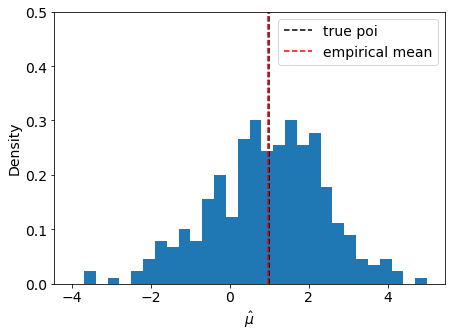

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 5)

ax.set_xlabel(r"$\hat{\mu}$")
ax.set_ylabel("Density")
ax.set_ylim(top=0.5)

ax.hist(muhat, bins=np.linspace(-4, 5, 31), density=True)
ax.axvline(true_poi, label="true poi", color="black", linestyle="dashed")
ax.axvline(np.mean(muhat), label="empirical mean", color="red", linestyle="dashed")
ax.legend();

Here we define the asymptotic profile likelihood test statistics:
$$t_\mu = \frac{(\mu-\hat\mu)^2}{\sigma^2}$$

$$\tilde{t}_\mu =
\begin{cases}
t_\mu,\;\text{$\hat{\mu}>0$}\\
t_\mu - t_0,\; \text{else}
\end{cases}
$$



$$q_\mu =
\begin{cases}
t_\mu,\;\text{$\hat{\mu}<\mu$}\\
0,\; \text{else}
\end{cases}
$$

$$\tilde{q}_\mu =
\begin{cases}
\tilde{t}_\mu,\;\text{$\hat{\mu}<\mu$}\\
0,\; \text{else}
\end{cases}
$$

In [12]:
def tmu_asymp(mutest, muhat, sigma):
    return (mutest - muhat) ** 2 / sigma ** 2


def tmu_tilde_asymp(mutest, muhat, sigma):
    a = tmu_asymp(mutest, muhat, sigma)
    b = tmu_asymp(mutest, muhat, sigma) - tmu_asymp(0.0, muhat, sigma)
    return np.where(muhat > 0, a, b)


def qmu_asymp(mutest, muhat, sigma):
    return np.where(
        muhat < mutest, tmu_asymp(mutest, muhat, sigma), np.zeros_like(muhat)
    )


def qmu_tilde_asymp(mutest, muhat, sigma):
    return np.where(
        muhat < mutest, tmu_tilde_asymp(mutest, muhat, sigma), np.zeros_like(muhat)
    )

And now we can compare them to the empirical values:

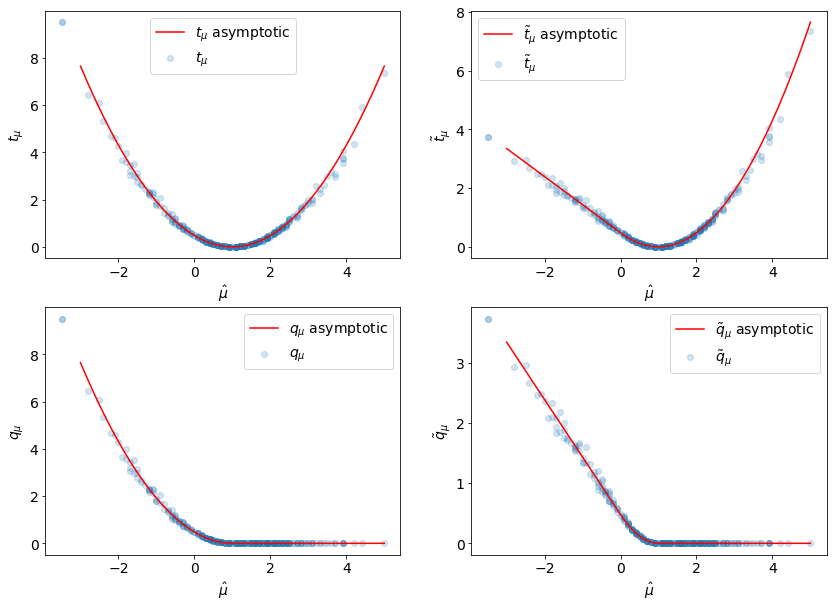

In [13]:
muhat_asymp = np.linspace(-3, 5)
fig, axarr = plt.subplots(2, 2)
fig.set_size_inches(14, 10)

labels = [r"$t_{\mu}$", "$\\tilde{t}_{\\mu}$", r"$q_{\mu}$", "$\\tilde{q}_{\\mu}$"]
data = [
    (tmu, tmu_asymp),
    (tmu_tilde, tmu_tilde_asymp),
    (qmu, qmu_asymp),
    (qmu_tilde, qmu_tilde_asymp),
]

for ax, (label, d) in zip(axarr.ravel(), zip(labels, data)):
    empirical, asymp_func = d
    ax.scatter(muhat, empirical, alpha=0.2, label=label)
    ax.plot(
        muhat_asymp,
        asymp_func(1.0, muhat_asymp, muhat_sigma),
        label=f"{label} asymptotic",
        c="r",
    )
    ax.set_xlabel(r"$\hat{\mu}$")
    ax.set_ylabel(f"{label}")
    ax.legend(loc="best")